In [3]:

import sys

command_str = '{sys.executable} -m pip install --upgrade wikipedia'.format(sys=sys)
print(command_str)
!{command_str}

C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade wikipedia
Processing c:\users\577342\appdata\local\pip\cache\wheels\87\2a\18\4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a\wikipedia-1.4.0-cp37-none-any.whl


In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%pprint
%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py
%run ../../load_magic/charts.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

dir()

Pretty printing has been turned OFF
D:\Documents\Repositories\notebooks\covid19\ipynb\Average Temperature.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'FACEBOOK_ASPECT_RATIO', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', 'TWITTER_ASPECT_RATIO', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'ball_and_chain', 'bs', 'check_4_doubles', 'check_for_typos', 'colormaps_list', 'conjunctify_list', 'copyfile', 'csv', 'cycler', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'first_order_linear_scatterplot', 'get_classifier', 'get_color_cycler', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_inf_nan_mask', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebo

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"


----
# Scrape the Data

In [3]:

try:
    temps_df = s.load_object('temps_df')
except:
    tables_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature'
    tables_list = get_page_tables(tables_url)

No pickle exists at D:\Documents\Repositories\notebooks\covid19\saves\pickle\temps_df.pickle - attempting to load as csv.
No csv exists at D:\Documents\Repositories\notebooks\covid19\saves\csv\temps_df.csv - attempting to download from URL.
[(0, (191, 2))]


In [4]:

temps_df = tables_list[0].copy()
temps_df.columns = ['Country', 'Temperature']
temps_df.set_index('Country', drop=True, inplace=True)
temps_df.Temperature = temps_df.Temperature.map(lambda x: float(re.sub('−', '-', x)))
s.store_objects(temps_df=temps_df)
temps_df.sample(5)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\temps_df.pickle


,Temperature
Country,
Austria,6.35
Albania,11.40
Mongolia,-0.70
Tuvalu,28.00
Nepal,8.10


In [7]:

# https://ourworldindata.org/covid-deaths
# https://twitter.com/Roshan_Karia/status/1257726938946449408
# Can you tell how many covid deaths happened in Singapore?
try:
    covid_deaths_df = s.load_object('covid_deaths_df')
except:
    covid_deaths_df = s.load_csv('cumulative_deaths_by_country').groupby('location').total_deaths.max().to_frame()
    covid_deaths_df.index.name = 'Country'
    covid_deaths_df.columns = ['Deaths']
    s.store_objects(covid_deaths_df=covid_deaths_df)
covid_deaths_df.sample(5)

,Deaths
Country,
Cameroon,64
Burundi,1
Comoros,1
Liechtenstein,1
Anguilla,0


In [6]:

# Also then compare it population wise to any cold country
columns_list = ['Population']
country_populations_df = s.load_object('country_populations_df')[columns_list]
country_populations_df.sample(5)

,Population
Country,
Lesotho,2007201
Greenland (Denmark),56081
Saudi Arabia,34218169
Kosovo,1795666
Malta,493559



----
# Merge the Data

In [8]:

'Singapore' in set(country_populations_df.index).intersection(set(covid_deaths_df.index)).intersection(set(temps_df.index))

True

In [9]:

merge_df = country_populations_df.merge(covid_deaths_df, left_index=True, right_index=True, suffixes=('_country', '_deaths'))
merge_df = merge_df.merge(temps_df, left_index=True, right_index=True, suffixes=('_merge', '_temps'))
merge_df['Deaths_per_Capita'] = merge_df.apply(lambda row_series: row_series.Deaths/row_series.Population, axis='columns')
merge_df.sample(5)

,Population,Deaths,Temperature,Deaths_per_Capita
Country,,,,
Bosnia and Herzegovina,3301000,78,9.85,0.000024
United States,329538591,68934,8.55,0.000209
Malaysia,32753760,105,25.40,0.000003
Sierra Leone,7901454,9,26.05,0.000001
Japan,125950000,521,11.15,0.000004


In [10]:

merge_df['Log_Deaths_per_Capita'] = merge_df.Deaths_per_Capita.map(lambda x: np.log(x))

In [ ]:

cold_war_list = ['Belgium', 'Canada', 'Denmark', 'France', 'Germany', 'Greece', 'Iceland', 'Italy', 'Luxembourg', 'Netherlands',
                 'Norway', 'Portugal', 'Spain', 'Turkey', 'United', 'Kingdom', 'USA']
us_aligned_list = ['Israel', 'Japan', 'South', 'Korea']
former_colonies_list = ['Australia', 'New Zealand']
neutral_industrialized_list = ['Austria', 'Ireland', 'Sweden', 'Switzerland']
first_world_list = cold_war_list + us_aligned_list + former_colonies_list + neutral_industrialized_list

In [ ]:

# https://www.nationsonline.org/oneworld/second_world.htm
second_world_list = s.load_csv('second_world_countries').Country.tolist()
second_world_list = list(set(second_world_list).intersection(set(merge_df.index)))

In [ ]:

def f(x):
    x = str(x)
    if x in first_world_list:
        return_value = 'First World'
    elif x in second_world_list:
        return_value = 'Second World'
    else:
        return_value = 'Third World'
    
    return return_value
merge_df['World_Label'] = merge_df.index.map(f)


----
# Plot the Data

In [ ]:

color_cycler = get_color_cycler(len(merge_df.World_Label.unique()))
color_dict = {}
for world_label, face_color_dict in zip(merge_df.World_Label.unique(), color_cycler()):
    face_color = face_color_dict['color']
    color_dict[world_label] = face_color
color_list = [color_dict[world_label] for world_label in df.World_Label]

In [11]:

inf_nan_mask = get_inf_nan_mask(merge_df.Temperature.values, merge_df.Log_Deaths_per_Capita.values)
df = merge_df[pd.Series(inf_nan_mask, index=merge_df.index)]

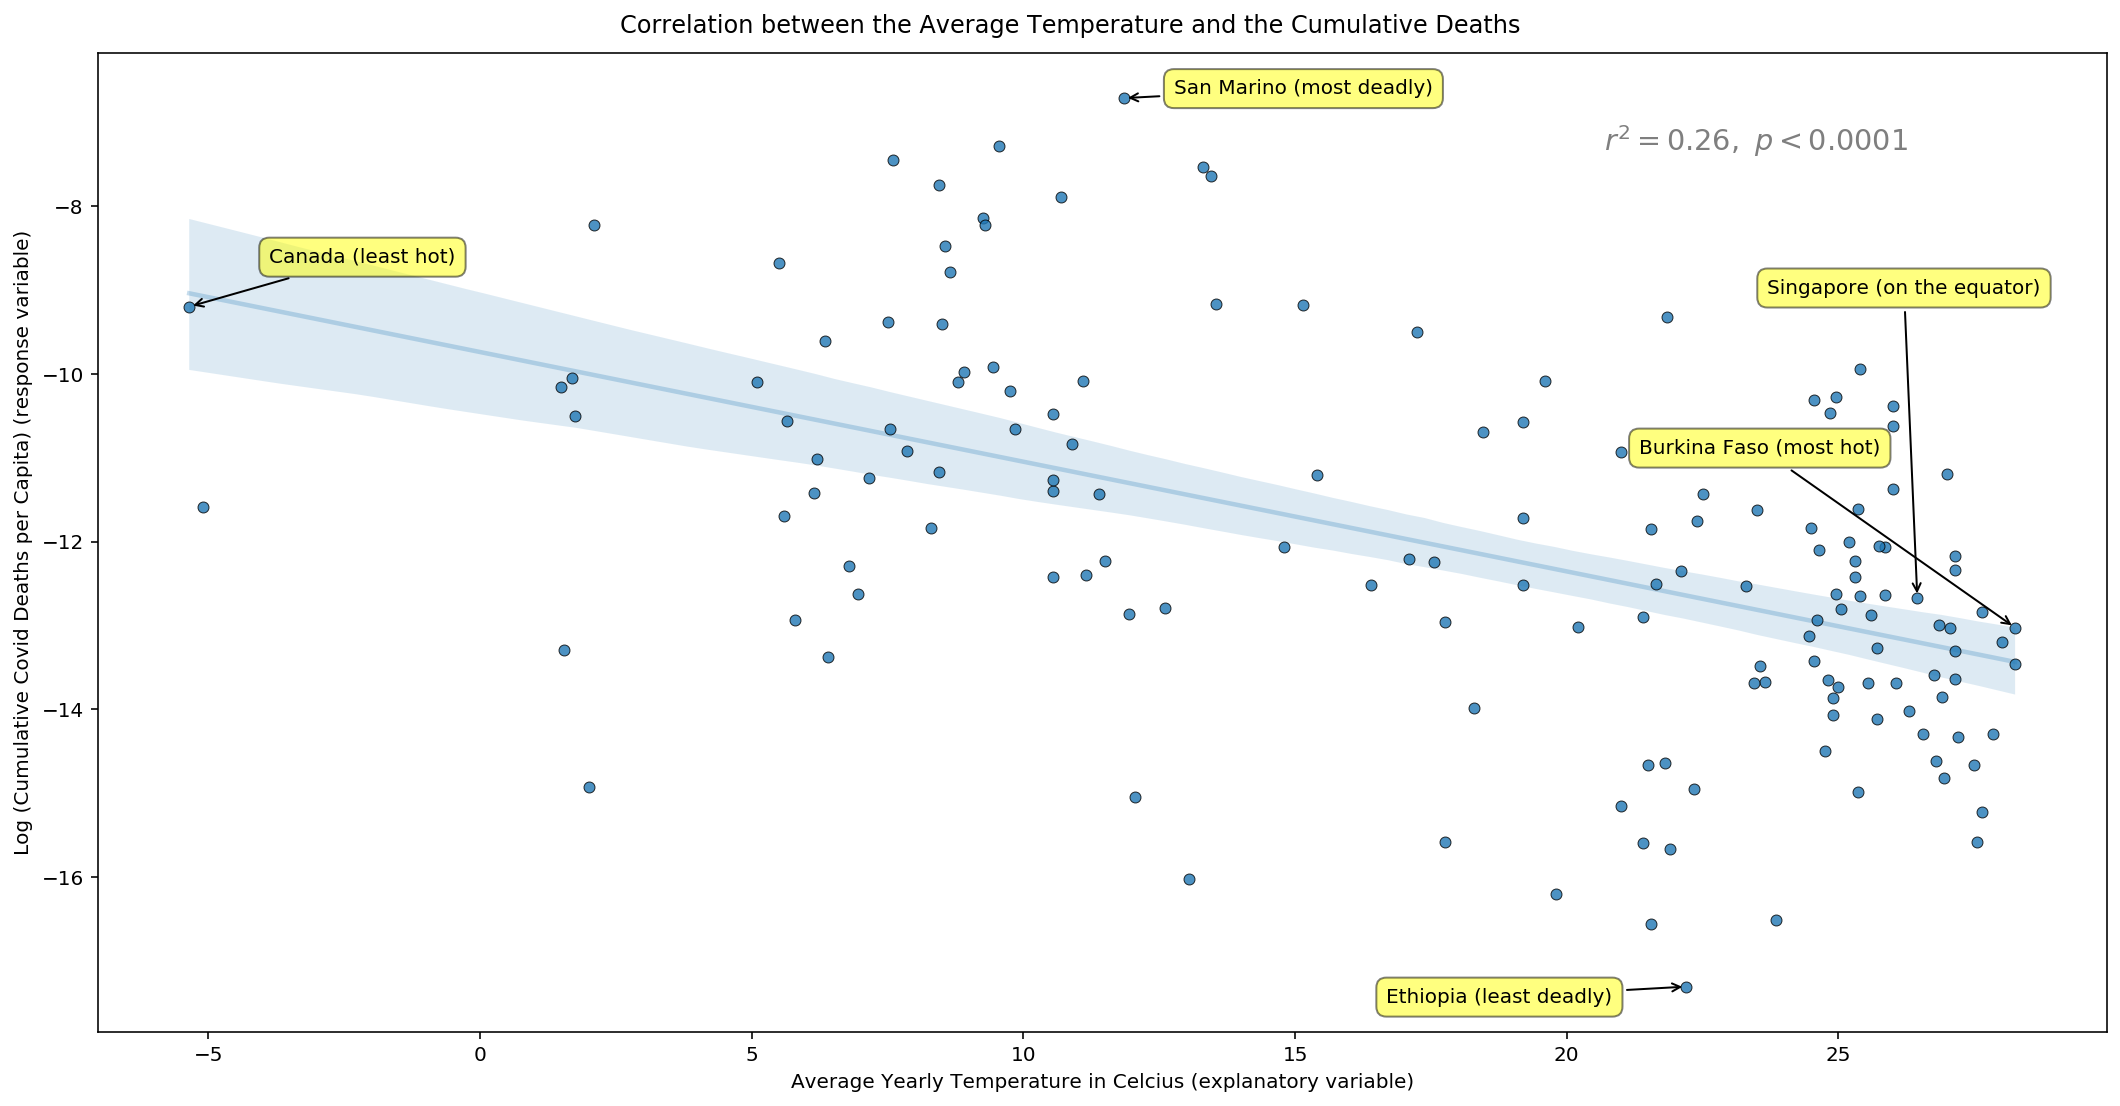

In [14]:

# https://twitter.com/Roshan_Karia/status/1257726938946449408
title_text = 'Correlation between the Average Temperature and the Cumulative Deaths'
first_order_linear_scatterplot(df, 'Temperature', 'Log_Deaths_per_Capita',
                               xlabel_str='Average Yearly Temperature in Celcius (explanatory variable)',
                               ylabel_str='Log (Cumulative Covid Deaths per Capita) (response variable)',
                               x_adj='hot', y_adj='deadly', title=title_text, idx_reference='Singapore',
                               annot_reference='on the equator', aspect_ratio=18/9,
                               least_x_xytext=(40, 20), most_x_xytext=(-188, 85),
                               least_y_xytext=(-150, -10), most_y_xytext=(25, 0),
                               reference_xytext=(-75, 150))